# Preliminaries

In [1]:
# General data and plotting
import json
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# Get Data

In [2]:
# Get Data and Format File

# get file
JsonFile = open('rideshare_user_history.json', 'r').read()  # reads text of file as string
JsonLoad = json.loads(JsonFile)  # converts string to parsed json

# convert list of dictionaries to pd.Dataframe
Df = pd.DataFrame(JsonLoad)

# Prepare Data

### convert types

In [3]:
# dates
Df['last_trip_date'] = pd.to_datetime(Df['last_trip_date'])
Df['signup_date'] = pd.to_datetime(Df['signup_date'])

# create target variable (based on date field)
TimeCutoff = Df['last_trip_date'].max() - dt.timedelta(days=30)
Df['churn'] = np.where(Df['last_trip_date'] < TimeCutoff, 1, 0)

# convert dates to numeric
date_diff = (Df['signup_date'] - Df['signup_date'].min())
Df['days_from_first_signup'] = date_diff.astype('timedelta64[D]').astype('float')

# categorical
Df['city'] = Df['city'].astype('category')
Df['phone'] = Df['phone'].astype('category')

# boolean
Df['black_car_user'] = np.where(Df['black_car_user'] == True, 1, 0)

# continuous (percents)
Df['weekday_pct'] = Df['weekday_pct'].astype('float')/100
Df['surge_pct'] = Df['surge_pct'].astype('float')/100
Df['trips_in_first_30_days'] = Df['trips_in_first_30_days'].astype(np.float)

### impute values

In [5]:
# rating of driver
ImpValArod = Df['avg_rating_of_driver'].mean()
Df['avg_rating_of_driver'] = Df['avg_rating_of_driver'].fillna(ImpValArod)

# phone
ImpValPhone = 'Other'
Col = Df['phone'].cat.add_categories(ImpValPhone)
Col = Col.fillna(ImpValPhone)
Df['phone'] = Col

# rating by driver
ImpValArbd = Df['avg_rating_by_driver'].mean()
Df['avg_rating_by_driver'] = Df['avg_rating_by_driver'].fillna(ImpValArbd)

# Feature Scaling and Preprocessing

In [6]:
# isolate target
y = np.where(Df['churn'] == True, 1, 0)

# dummify category variables
onehot = pd.get_dummies(Df[['phone', 'city']])
Df = pd.concat([Df, onehot], axis=1)

# drop unneeded fields
to_drop = ['signup_date','last_trip_date', 'phone', 'city', 'churn']
Df = Df.drop(to_drop, axis=1)

In [7]:
from sklearn import preprocessing
# convert dataframe to tensors (vectors and matrices)

# convert continuous variables to standard scalar
scaler = preprocessing.StandardScaler()
features_cont = Df.dtypes[Df.dtypes.values == 'float64'].index.tolist()
X_cont = Df[features_cont].as_matrix().astype(np.float)
X_cont = scaler.fit_transform(X_cont)

# create boolean features 
features_bool = Df.dtypes[Df.dtypes.values != 'float64'].index.tolist()
X_bool = Df[features_bool].as_matrix().astype(np.float)

# aggregate features
features = features_cont + features_bool
X = np.hstack([X_cont, X_bool])

# create dataframe
DfScaled = pd.DataFrame(X, columns=features)
DfScaled['churn'] = y

# Tuning Random Forest

### baseline accuracy

In [8]:
# get ZeroR accuracy
print y.mean()

0.62392


In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

# get rf accuracy with out of box settings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestClassifier(n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print 'Training accuracy:', round(rf.score(X_train, y_train), 4)
print 'Test accuracy:', round(rf.score(X_test, y_test), 4)

/Users/Cronin/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training accuracy: 0.9864
Test accuracy: 0.753


### k-fold cross validation accuracy

In [19]:
from sklearn.model_selection import cross_val_score

# efficient cv code
scores = cross_val_score(estimator=rf, X=X, y=y, cv=10, n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.74865027  0.75824835  0.74705059  0.74985003  0.7454      0.7498
  0.75195039  0.76075215  0.76195239  0.74874975]
CV accuracy: 0.752 +/- 0.006


### other metrics

In [14]:
from sklearn import metrics

# Accuracy, AUC, Precision, Recall, F1
print 'Key Metrics \n******************'
print 'Accuracy: %.3f' % metrics.accuracy_score(y_true=y_test, y_pred=y_pred_rf)
print 'ROC AUC: %.3f' % metrics.roc_auc_score(y_true=y_test, y_score=y_pred_rf)
print 'Classification Report: \n\n {0}'.format(metrics.classification_report(y_test, y_pred_rf))

Key Metrics 
******************
Accuracy: 0.753
ROC AUC: 0.741
Classification Report: 

              precision    recall  f1-score   support

          0       0.67      0.69      0.68      3822
          1       0.80      0.79      0.80      6178

avg / total       0.75      0.75      0.75     10000



# Bias/Variance and Accuracy

### learning curves

In [12]:
# tells you how accurate model becomes with more data
from sklearn.model_selection import learning_curve

# create cv estimates for range of train_sizes
train_sizes, train_scores, test_scores = \
    learning_curve(
        estimator=rf,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=10,
        n_jobs=-1
        )

# get mean + sd, and plot
train_mean_lc = np.mean(train_scores, axis=1)
train_std_lc = np.std(train_scores, axis=1)
test_mean_lc = np.mean(test_scores, axis=1)
test_std_lc = np.std(test_scores, axis=1)

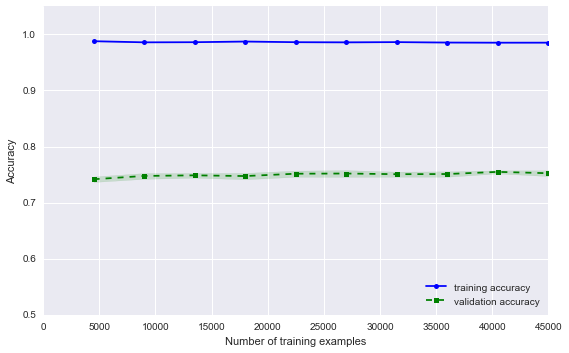

In [13]:
train_mean = train_mean_lc; train_std = train_std_lc
test_mean = test_mean_lc; test_std = test_std_lc

# plot both curves
plt.figure(figsize=(8,5))  # graph size

plt.plot(train_sizes, train_mean,  # training data
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,  # training data ranges
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,  # test data
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,  # test data ranges
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# formatting
plt.xlabel('Number of training examples'); plt.ylabel('Accuracy')
plt.ylim(0.5, 1.05)
plt.legend(loc='lower right'); plt.tight_layout()

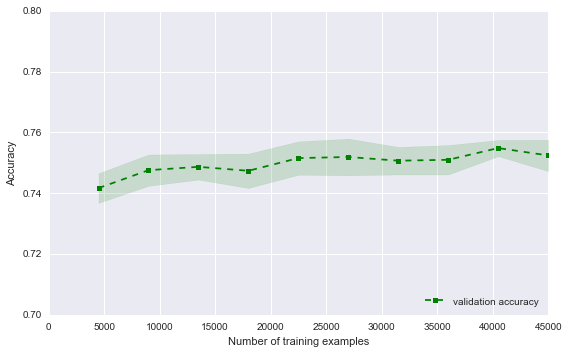

In [14]:
# plot validation curve-only
plt.figure(figsize=(8,5))  # graph size

plt.plot(train_sizes, test_mean,  # test data
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,  # test data ranges
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# formatting
plt.xlabel('Number of training examples'); plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)
plt.legend(loc='lower right'); plt.tight_layout()

### validation curve

In [23]:
# addresses over/underfitting with different parameter estimates
from sklearn.model_selection import validation_curve

# Validation Curve: iterate through levels of a parameter to see impact on accuracy
#   Uses CV to get ranges of accuracy scores
param_range = [10, 20, 50, 75, 100, 250, 500]

# get cross validation scores
train_scores, test_scores = \
    validation_curve(estimator=rf,
                     X=X,
                     y=y,
                     param_name='n_estimators',
                     param_range=param_range,
                     cv=10)

# get mean + sd, and plot
train_mean_vc = np.mean(train_scores, axis=1)
train_std_vc = np.std(train_scores, axis=1)
test_mean_vc = np.mean(test_scores, axis=1)
test_std_vc = np.std(test_scores, axis=1)

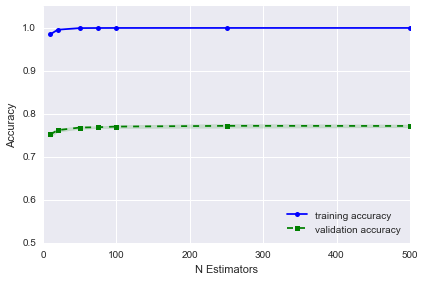

In [24]:
train_mean = train_mean_vc; train_std = train_std_vc
test_mean = test_mean_vc; test_std = test_std_vc

# plot both curves
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.xlabel('N Estimators'); plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

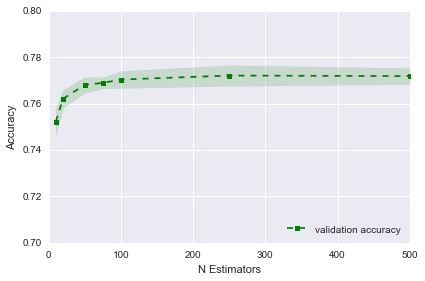

In [25]:
# plot validation curve only
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.xlabel('N Estimators'); plt.ylabel('Accuracy')
plt.ylim([0.70, 0.80])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Grid Search Optimization

In [34]:
# tuning more than 1 hyperparameter
from sklearn.model_selection import GridSearchCV

# create parameter ranges
# rf parameters for accuracy: max_features, n_estimators, min_sample_leaf
# rf parameters for easier training: n_jobs, random_state, oob_score
max_features = [2, 3, 4, 5]  # default is sqrt(n_features)
min_sample_leaf = [8, 10, 12, 14, 16]  # default is 1

# create hyperparameter "grid"
hyperparameters = {
    'max_features': max_features,
    'min_samples_leaf': min_sample_leaf,
    }

In [37]:
# create grid search object with embedded CV method
gridCV = GridSearchCV(
    RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1),
    param_grid=hyperparameters,
    scoring='f1',  # try 'accuracy' and 'f1'
    cv=10,
    n_jobs=-1
    )

# perform grid search
gridCV.fit(X, y)

# identify optimal values
best_max_features     = gridCV.best_params_['max_features']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']
# best_n_estimators     = gridCV.best_params_['n_estimators']

print("The best performing max_features     value is: {}".format(best_max_features))
print("The best performing min_samples_leaf value is: {}".format(best_min_samples_leaf))

The best performing max_features     value is: 2
The best performing min_samples_leaf value is: 10


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


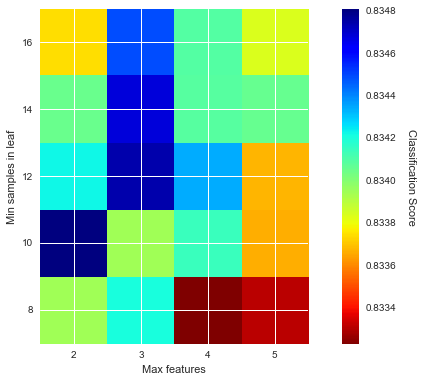

In [38]:
# plot grid search results
def gridcv_heatmap(name1, range1, name2, range2):
    # fetch scores, reshape into a grid
    scores = [x[1] for x in gridCV.grid_scores_]
    scores = np.array(scores).reshape(len(range1), len(range2))
    scores = np.transpose(scores)

    # Make heatmap from grid search results
    plt.figure(figsize=(12, 6))
    plt.imshow(scores, interpolation='nearest', origin='higher', cmap='jet_r')
    plt.xticks(np.arange(len(range1)), range1); plt.xlabel(name1)
    plt.yticks(np.arange(len(range2)), range2); plt.ylabel(name2)
    plt.colorbar().set_label('Classification Score', rotation=270, labelpad=20)
    plt.show()

name1 = 'Max features'; range1 = max_features
name2 = 'Min samples in leaf'; range2 = min_sample_leaf

gridcv_heatmap(name1, range1, name2, range2)

In [51]:
# best accuracy: max_features = 3, min_samples = 12
# best f1: max_features = 2, min_samples = 10

In [43]:
rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=10,
    max_features=2,
    random_state=0,
    n_jobs=-1)

# Other Performance Metrics

### confusion matrix

[[11975  6829]
 [ 3968 27228]]


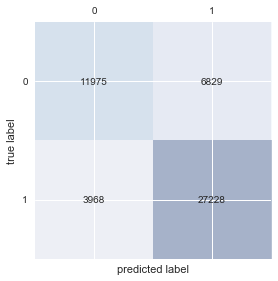

In [44]:
import itertools

# create confusion matrix object
y_pred = cross_val_predict(estimator=rf, X=X, y=y)
cm_svc = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
print cm_svc

# plot confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(cm_svc, cmap=plt.cm.Blues, alpha=0.3)
for i, j in itertools.product(range(cm_svc.shape[0]), range(cm_svc.shape[1])):
    ax.text(x=j, y=i, s=cm_svc[i, j], va='center', ha='center')
plt.xlabel('predicted label'); plt.ylabel('true label')
plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

# exercise: draw confusion matrix with fn/tp, tn/fp
# exercise: define tpr and fpr in the context of the matrix, give an analogy for tpr and fpr
# exercise: do the same for precision and recall

### precision, recall, f1

In [54]:
# Accuracy: correct predictions on positive and negative class
# Error: incorrect predictions on positive and negative class

# Precsion: % of cancer guesses that were correct
# TPR/Recall: correctly diagnose people who are sick
# FPR: misdiagnose people who are not sick

# get precision and recall
print 'Precision: %.3f' % metrics.precision_score(y_true=y_test, y_pred=y_pred)
print 'Recall: %.3f' % metrics.recall_score(y_true=y_test, y_pred=y_pred)
print 'F1: %.3f' % metrics.f1_score(y_true=y_test, y_pred=y_pred)

# exercise: how is f1 calculated?  why is it the harmonic mean and not the geometric mean?

Precision: 0.798
Recall: 0.873
F1: 0.834


### roc curve and auc

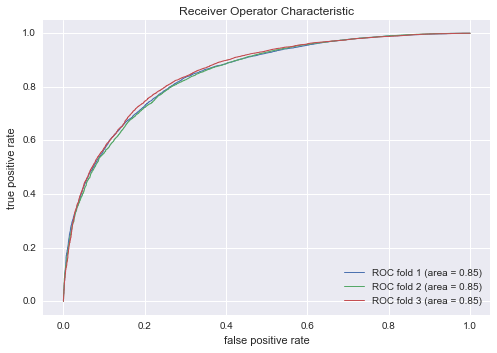

In [55]:
from sklearn.model_selection import StratifiedKFold
from scipy import interp

# create cross validation object with fewer splits to make model worse
# stratified kfold to preserve class distribution
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X, y))

# Plot roc curve
fig = plt.figure(figsize=(7, 5))

# loop through 3-fold cross-validation object
for i, (train, test) in enumerate(cv):
    # get scores
    probas = rf.fit(X[train], y[train]).predict_proba(X[test])

    # create vectors of fpr, tpr, thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y[test], probas[:, 1], pos_label=1)
    
    # area under the roc curve
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate'); plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic'); plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### precision recall curve

In [56]:
from scipy import interp

# create cross validation object with fewer splits to make model worse
# stratified kfold to preserve class distribution
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X, y))

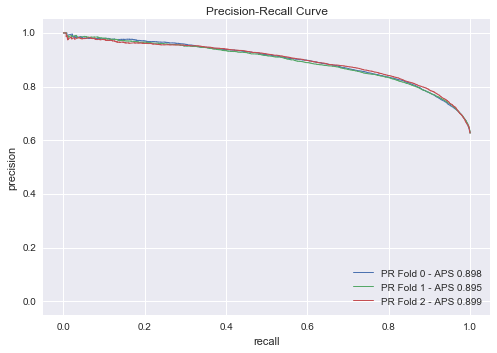

In [57]:
# Plot precision-recall curves
fig = plt.figure(figsize=(7, 5))

# loop through 3-fold cross-validation object
for i, (train, test) in enumerate(cv):

    # get scores
    probas = rf.fit(X[train], y[train]).predict_proba(X[test])

    # create vectors of fpr, tpr, thresholds
    precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas[:, 1], pos_label=1)
    # score
    aps = round(metrics.average_precision_score(y_true=y[test], y_score=probas[:, 1]), 3)
    
    # plot
    plt.plot(recall, precision, lw=1, label='PR Fold {0} - APS {1}'.format(str(i), aps))

# labels
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.xlabel('recall'); plt.ylabel('precision')
plt.title('Precision-Recall Curve'); plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### summary report

In [46]:
print('ROC AUC: %.3f' % metrics.roc_auc_score(y_true=y, y_score=y_pred))
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=y, y_pred=y_pred))
print('Classification Report: \n\n {0}'.format(metrics.classification_report(y, y_pred)))

ROC AUC: 0.755
Accuracy: 0.784
Classification Report: 

              precision    recall  f1-score   support

          0       0.75      0.64      0.69     18804
          1       0.80      0.87      0.83     31196

avg / total       0.78      0.78      0.78     50000



# Feature Importance

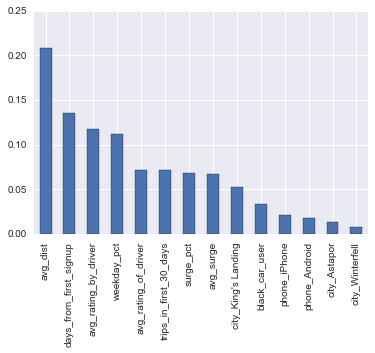

In [39]:
# check relative importance of features as an fyi
rf_importances = rf.feature_importances_.tolist()
pd.Series(rf_importances, index=features).sort_values(ascending=False).plot(kind='bar')